# Libraries

In [1]:
import os
import re
import sys
import json
import math
import nltk
import torch
import spacy
import pathlib
import logging
import inflect
import warnings
import sng_parser
import subprocess

import numpy as np
import torch.nn as nn
import tensorflow as tf

import torchvision.models as models_trch
import torchvision.transforms as transforms
import torchvision.transforms.functional as TVTF

from tqdm import tqdm
from glob import glob
from string import punctuation
from PIL import Image as PIL_Image
from statistics import median, mean
from collections import Counter, defaultdict

from torch.nn import functional as F
from torch.autograd import Variable as V

from torchvision import transforms
from torchvision.utils import save_image
from torchvision.io import read_image, ImageReadMode
from torchvision.models.segmentation import fcn_resnet50
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms.functional import convert_image_dtype, InterpolationMode

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer

from BLIP.models.blip_vqa import blip_vqa
from BLIP.models.blip import blip_decoder
from big_phoney.big_phoney import BigPhoney 

punctuation = punctuation.replace("'","")

try:
  nltk.data.find('corpora/wordnet.zip')
except LookupError:
  nltk.download('wordnet')

punkt_path = os.path.join(nltk.data.find('tokenizers').path, 'punkt')
if not os.path.exists(punkt_path):
    nltk.download('punkt')
 
try:
  nltk.data.find('taggers/averaged_perceptron_tagger.zip')
except LookupError:
  nltk.download('averaged_perceptron_tagger')
    
try:
  nltk.data.find('corpora/omw-1.4.zip')
except LookupError:
  nltk.download('omw-1.4')
  
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

2025-03-17 19:51:47.844602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-17 19:51:48.487497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/daniel/miniconda3/envs/phd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Modules

## VIE MAIN

In [57]:
def load_image(image, image_size, device, dataset_path, file_format):

    img = dataset_path + str(image) + file_format  
    
    img = PIL_Image.open(img)
    raw_image = img.convert("RGB") 

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
        
    image = transform(raw_image).unsqueeze(0).to(device)
    return image, raw_image

def vqa_captions(img, question, model, threshold_yes, device, dataset_path, file_format):

    captions = []
    image, _ = load_image(img, 480, device, dataset_path, file_format)

    with torch.no_grad():
        question = question + "?"
        answer, confidence = model(image, question, train=False, inference='generate')

        if answer[0] == "yes":
          if confidence[0].cpu().numpy() >= threshold_yes: return True

    return False 

def vqa_basic(img, question, model, device, dataset_path, file_format):

    answers = []
    image, raw = load_image(img, 480, device, dataset_path, file_format)

    display(raw)

    with torch.no_grad():
        for i, q in enumerate(question):

          if i == 5 or i == 6:
            if answers[4] == 'yes':
              answers.append('None')
              continue

          elif i == 8:
            if answers[7] == 'no':
              answers.append('None')
              continue

          elif i == 10 or i == 11:
            if answers[9] == 'no':
              answers.append('None')
              continue

          elif i == 14 or i == 15:
            if answers[13] == 'no':
              answers.append('None')
              continue    
            elif i == 15: q = "%s colors?" % answers[14]

          elif i == 18: q = "does the %s have more than one color?" % answers[17]

          elif i == 19:
            if answers[18] == 'yes': word = 'colors are'
            else: word = 'color is'
            
            q = "what %s the %s?" % (word, answers[17])
            
          answer, confidence = model(image, q+"?", train=False, inference='generate')

          if i == 1:
            is_int = represents_int(answer[0])
            
            if is_int: answers.append(answer[0])  
            else:
              if answer[0] == "middle-aged" or answer[0] == "middle aged":
                age = 55
                answers.append(age)
                
              else:
                age = 33
                answers.append(age)
                
          else:
            answers.append(answer[0])
    return answers

def represents_int(s):
    try:
        int(s)
    except ValueError:
        return False
    else:
        return True

def age_group(apparent_age):

  if apparent_age < 10:
    group = 'child'
  elif apparent_age < 20:
    group = 'young'
  elif apparent_age < 45:
    group = 'adult'
  elif apparent_age < 65:
    group = 'midlife'
  else:
    group = 'elderly'

  return group

def check_is_vowel(text, phoney, next_word=False):

    if text == "":
      text = next_word

    text = text.strip()
    text = phoney.phonize(text).lower()
    first_char = text.split()

    vowel = ["a", "e", "i", "o", "u"]
    
    if first_char[0][0] in vowel: return 'an'
    else: return 'a'

def is_singular(word, inflect, phoney):

  if inflect.singular_noun(word) == False:
    res = check_is_vowel(word, phoney)
    return res
    
  else: return ''

def join_separate(answer):

  new =  ''
  
  if len(answer.split()) > 1:
    for i, words in enumerate(answer.split()):
      if i < len(answer.split())-1: new += words + "_"
      else: new += words
      
    answer = new
    
  return answer

def generate_dense_captions_vqa(answers, phoney, inflect):

  subject = answers[0]

  age = age_group(int(answers[1]))
  
  if age == 'adult': age = ''
  elif age == 'child':
    if subject == 'man': subject = 'boy'
    else: subject = 'girl'
    
    age = ''

  place = answers[20]
  
  if place == 'home': at_in = 'at'
  else: at_in = 'in the'

  place = join_separate(place)

  objects = answers[21]
  objects = join_separate(objects)

  dense_captions = [
  "%s %s %s %s with %s expression." % (check_is_vowel(age, 
                                                      phoney, 
                                                      answers[2]).capitalize(), 
                                                      age, 
                                                      answers[2], 
                                                      subject, 
                                                      answers[16]),
  "The %s is wearing %s %s %s." % (subject, 
                                   check_is_vowel(answers[19], phoney), 
                                   answers[19], 
                                   answers[17]),
  "The %s has %s eyes." % (subject, answers[3]),
  "The %s is bald." % (subject),
  "The %s has %s hair." % (subject, answers[6]),
  "The %s has %s hair." % (subject, answers[5]),
  "The %s has %s mustache." % (subject, answers[8]),
  "The %s has %s beard." % (subject, answers[10]),
  "The %s has %s beard." % (subject, lemmatize_subject(answers[11])),
  "The %s is wearing makeup." % (subject),
  "The %s is wearing %s %s." % (subject, answers[15], answers[14]),
  "The %s is %s %s, with %s %s in the background." % (subject, 
                                                             at_in, 
                                                             place, 
                                                             is_singular(answers[21], inflect, phoney), 
                                                             answers[21])]

  sentences = []
  sentences_not_fisio = []
  
  is_bald = False
  use_acessory = False

  for qi, caption in enumerate(dense_captions):
    if 0 <= qi < 10:
      if qi == 1: sentences_not_fisio.append(caption)
      elif qi == 2:
        if answers[22] == "yes": sentences.append(caption)
      elif qi == 3:
        if answers[4] == "yes":
          is_bald = True
          sentences.append(caption)
      elif qi == 4:
        if is_bald == False: sentences.append(caption)
      elif qi == 5:
        if is_bald == False: sentences.append(caption)
      elif qi == 6:
        if answers[7] == "yes": sentences.append(caption)
      elif qi == 7:
        if answers[9] == "yes": sentences.append(caption)
      elif qi == 8:
        if answers[9] == "yes": sentences.append(caption)
      elif qi == 9:
        if answers[12] == "yes": sentences_not_fisio.append(caption)
      else:
        sentences.append(caption)
        
    else:
      if qi > 9:
        if qi == 10:
          if answers[13] == "yes": sentences_not_fisio.append(caption)
        else: sentences_not_fisio.append(caption)
      else: sentences.append(caption)

  return sentences, sentences_not_fisio, subject

## VIE COMP

In [58]:
def is_body_part(word, nlp): 

  part = wordnet.synsets('body_part')[0]

  for j,ss in enumerate(wordnet.synsets(word)):
    if j < 5:
      name = ss.name().split(".", 1)[0]
      if name != word:
          continue

      hit = part.lowest_common_hypernyms(ss)

      if hit and hit[0] == part:
          doc = nlp(name)
          if doc[0].pos_== 'ADJ': return False
          else: return True

  return False

def sentences_linguistically_acceptable_classify(captions, tokenizer_rob, model_rob):
  class_id = []
  probs = []

  for txt in captions:
    inputs = tokenizer_rob(txt, return_tensors="pt")

    with torch.no_grad():
        logits = model_rob(**inputs).logits

    predicted_class_id = logits.argmax().item()
    class_id.append(predicted_class_id)
    predictions = tf.nn.softmax(logits)
    max_prob = max(tf.keras.backend.get_value(predictions)[0])
    probs.append(max_prob)

  return class_id, probs

def check_densecap_similarity(regions, nlp, threshold_similar, tokenizer_rob, model_rob, stop_word):

  check_sim = []

  for region in regions:
    description = region.lower()
    description = description.strip(" ")
    description = ''.join(c for c in description if c not in punctuation)
    description = ' '.join(re.split("\s+", description, flags=re.UNICODE))
    parsedData = nlp(description)

    if stop_word:
      parsedData = nlp(' '.join([str(t) for t in parsedData if not t.is_stop]))

    if not check_sim:
      if len(parsedData) <= 2:
        short = False
        for word in parsedData:
          anwser = is_body_part(lemmatize_subject(str(word)), nlp)
          if anwser:
            short = True
            break
              
        if short != True:
          check_sim.append(description.capitalize() + '.')

      else:
        check_sim.append(description.capitalize() + '.')

    else:
      add = True
      for d in check_sim:
        cap = d.lower()
        cap = cap.strip(" ")
        cap = ''.join(c for c in cap if c not in punctuation)
        final_cap = nlp(cap)

        if stop_word:
          final_cap = nlp(' '.join([str(t) for t in final_cap if not t.is_stop]))

        similarity = round(parsedData.similarity(nlp(final_cap)), 2)
        if similarity >= threshold_similar:
          add = False
          if similarity < 1.0:
            captions_compare = [cap, description]
            classes_ids = []
            probabilities = []
            new = []
            classes_ids, probabilities = sentences_linguistically_acceptable_classify(captions_compare, tokenizer_rob, model_rob)
            add = False

            if classes_ids[0] == 0 and classes_ids[1] == 1:
              check_sim.remove(d)
              check_sim.append(description.capitalize() + '.')

            elif classes_ids[0] == 0 and classes_ids[1] == 0:
              if probabilities[0] > probabilities[1]:
                check_sim.remove(d)
                check_sim.append(description.capitalize() + '.')

            elif classes_ids[0] == 1 and classes_ids[1] == 1:
              if probabilities[0] < probabilities[1]:
                check_sim.remove(d)
                check_sim.append(description.capitalize() + '.')

          break

      if add:
        if len(parsedData) <= 2:
          short = False
          for word in parsedData:
            anwser =  is_body_part(lemmatize_subject(str(word)), nlp)
            if anwser:
              short = True
              break
                
          if short != True:
            check_sim.append(description.capitalize() + '.')

        else:
          check_sim.append(description.capitalize() + '.')

  return check_sim


def check_similarity2(regions, captions_vqa, subject, nlp, threshold_similar, threshold_yes, image, model_vqa, device, dataset_path, file_format, stop_word):

  caps = []
  no_person = []
  check_sim = []

  for region in regions:
    description = region.lower()
    description = description.strip(" ")
    description = ''.join(c for c in description if c not in punctuation)
    description = ' '.join(re.split("\s+", description, flags=re.UNICODE))
    parsedData = nlp(description)

    if stop_word:
      parsedData = nlp(' '.join([str(t) for t in parsedData if not t.is_stop]))

    add = True
      
    for d in captions_vqa:
      cap_vqa = d.lower()
      cap_vqa = cap_vqa.strip(" ")
      cap_vqa = ''.join(c for c in cap_vqa if c not in punctuation)
      final_cap_vqa = nlp(cap_vqa)

      if stop_word:
        final_cap_vqa = nlp(' '.join([str(t) for t in final_cap_vqa if not t.is_stop]))

      similarity = round(parsedData.similarity(nlp(final_cap_vqa)), 2)
      if similarity >= threshold_similar:
        add = False
        break

    if add:
      if not check_sim:
        reg_bool = vqa_captions(image, description, model_vqa, threshold_yes, device, dataset_path, file_format)
        if reg_bool:
          check_sim.append(description.capitalize() + '.')
          for i, word in enumerate(parsedData):
            if i < len(parsedData)-1:
              if word.text.lower() == subject:
                caps.append(description.capitalize() + '.')
                break
                  
            else:
              if word.text.lower() == subject:
                caps.append(description.capitalize() + '.')
                break
                  
              else:
                no_person.append(description.capitalize() + '.')
                break

      else:
        add2 = True
        for d in check_sim:
          cap_vqa = d.lower()
          cap_vqa = cap_vqa.strip(" ")
          cap_vqa = ''.join(c for c in cap_vqa if c not in punctuation)
          final_cap_vqa = nlp(cap_vqa)

          if stop_word:
            final_cap_vqa = nlp(' '.join([str(t) for t in final_cap_vqa if not t.is_stop]))

          similarity = round(parsedData.similarity(nlp(final_cap_vqa)), 2)
          if similarity >= threshold_similar:
            add2 = False
            break

        if add2:
          reg_bool = vqa_captions(image, description, model_vqa, threshold_yes, device, dataset_path, file_format)
          if reg_bool:
            check_sim.append(description.capitalize() + '.')

            for i, word in enumerate(parsedData):
              if i < len(parsedData)-1:
                if word.text.lower() == subject:
                  caps.append(description.capitalize() + '.')
                  break
                    
              else:
                if word.text.lower() == subject:
                  caps.append(description.capitalize() + '.')
                  break
                    
                else:
                  no_person.append(description.capitalize() + '.')
                  break

  return caps, no_person

def lemmatize_subject(text):
  tag_map = defaultdict(lambda : wordnet.NOUN)
  tag_map['J'] = wordnet.ADJ
  tag_map['V'] = wordnet.VERB
  tag_map['R'] = wordnet.ADV

  tokens = word_tokenize(text)
  lemma_function = WordNetLemmatizer()
  for token, tag in pos_tag(tokens):
    lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
    break

  return lemma

## SSP

In [59]:
def pronoun_adjustment(paragraph, nlp):
  new_paragraph = ""

  for i, sentence in enumerate(paragraph.split(".")):

    if i == len(paragraph.split("."))-1: break
    else:

      sentence = sentence.strip()
      doc = nlp(sentence)

      for j, token in enumerate(doc):
        
        if token.pos_ == "NOUN" and (token.dep_ == "nsubj" or token.dep_ == "ROOT") and j != len(doc)-1:
          pronoun = ""
          if token.text.lower() == "man" or token.text.lower() == "boy": pronoun = 'He' 
          elif token.text.lower() == "woman" or token.text.lower() == "girl": pronoun = 'She' 
          else: continue
          
          if i > 0:
            if j-1 == 0: sentence = sentence.replace(("The %s" %  (token.text)), pronoun)
            else: sentence = sentence.replace(("%s" % token.text), pronoun)   
            break

        elif token.pos_ == "NOUN" and token.dep_ == "pobj": 
            pronoun = ""

            if doc[j-1].pos_ != 'DET':
                if token.text == "man" or token.text == "boy": pronoun = 'him' 
                elif token.text == "woman" or token.text == "girl": pronoun = 'her'
                else: pronoun = token.text

                sentence = sentence.replace((token.text), pronoun)
            break

      new_paragraph += sentence + ". "
  return new_paragraph
  
def extraction_relations(caps, parser, nlp):

  relations = []
  freq_rels = []
  adj_head  = []
  freq_head = []

  head = []

  adjs_dict = defaultdict(set)

  for x, phrase in enumerate(caps):
    
    gph = parser.parse(phrase.lower())
    #sng_parser.tprint(gph)

    if len(gph['relations']) > 0:

      doc = nlp(phrase)

      is_key = False
      is_adj = False

      for i, token in enumerate(doc):
        key = ""

        if token.pos_ == "NOUN" and (token.dep_ == 'ROOT' or token.dep_ == 'nsubj'):
          rel_in = False
          if len(gph['relations']) > 1:
            for rel in gph['relations']:
              if rel['relation'] == "in":
                key = token.text.lower() + "__" + rel['relation']
                rel_in = True
                break
                  
            if rel_in == False:
              key = token.text.lower() + "__" + gph['relations'][0]['relation']

          else:
            key = token.text.lower() + "__" + gph['relations'][0]['relation']
            
          relations.append(key)
          freq_rels.append(key)

          is_key = True

        elif token.pos_ == "ADJ":
          if token.dep_ == "ROOT": 
              continue

          elif is_adj != True:
            if token.head.text == token.text:
              previous = i-1
              next = i+1
                
              if doc[previous].pos_ == "NOUN" and doc[previous].dep_ == 'pobj':
                head_text = doc[previous].text

              elif doc[next].pos_ == "NOUN" and doc[next].dep_ == 'pobj':
                head_text = doc[next].text

              adj_head.append(head_text)
              freq_head.append(head_text)
              adjs_dict[head_text].add(token.text)

            else:
              adj_head.append(token.head.text)
              freq_head.append(token.head.text)
              adjs_dict[token.head.text].add(token.text)

            is_adj = True

      if is_key == False:
        for token in doc:
          if  token.pos_ == "NOUN" and token.dep_ == 'npadvmod':
            rel_in = False
            if len(gph['relations']) > 1:
              for rel in gph['relations']:
                if rel['relation'] == "in":
                  key = token.text.lower() + "__" + rel['relation']
                  rel_in = True
                  break
                    
              if rel_in == False:
                key = token.text.lower() + "__" + gph['relations'][0]['relation']

            else:
              key = token.text.lower() + "__" + gph['relations'][0]['relation']

            relations.append(key)
            freq_rels.append(key)

            is_key = True
            break

        if is_key != True:
          freq_rels.append(None)

      if is_adj == False:
        freq_head.append(None)

    else:
      doc = nlp(phrase)
      new_relation = False
      indice_freq_head = False
    
      is_adj = False
    
      for i, token in enumerate(doc):
        key = ""
        if token.pos_ == "NOUN" and (token.dep_ == 'nsubj' or token.dep_ == 'npadvmod'):
          for next in range(i+1, len(doc)):
            if doc[next].text == token.head.text and doc[next].pos_ == "VERB" and doc[next].dep_ == "ROOT":
              key = token.text.lower() + "__" + doc[next].text
              new_relation = True
              
            elif doc[next].pos_ == "NOUN" and doc[next].dep_ == "dobj":
              freq_head.append(doc[next].text)
              indice_freq_head = True

          if new_relation:
            break
        
        elif token.pos_ == "ADJ":
          if token.dep_ == "ROOT":
              continue

          elif is_adj != True:
            previous = i-1
            next = i+1
            
            if token.head.text == token.text: 
                if doc[previous].pos_ == "NOUN" and doc[previous].dep_ == 'pobj':
                    head_text = doc[previous].text
                    adj_noun = token.text  
                    indice_freq_head = True
                    is_adj = True

                elif doc[next].pos_ == "NOUN" and doc[next].dep_ == 'pobj':
                    head_text = doc[next].text
                    adj_noun = token.text  
                    indice_freq_head = True
                    is_adj = True

            else:
                if token.dep_ == "compound":
                    if doc[next].dep_ == "compound":
                        head_text = doc[next].text
                        adj_noun = token.text.lower()
                        indice_freq_head = True
                        is_adj = True
                else:
                    head_text = token.head.text
                    adj_noun = token.text
                    indice_freq_head = True
                    is_adj = True

      if new_relation:
        relations.append(key)
        freq_rels.append(key)
        
        if is_adj:
            adj_head.append(head_text)
            freq_head.append(head_text)
            adjs_dict[head_text].add(adj_noun)
        
        if indice_freq_head == False:
          freq_head.append(None)
                                 
      else:
        freq_rels.append(None)
        freq_head.append(None)

  rel_list = Counter()
  for sub_rel in relations:
    rel_list[sub_rel] += 1

  rel_adj_head = Counter()
  for head in adj_head:
    rel_adj_head[head] += 1

  for head in rel_adj_head:
    if rel_adj_head[head] < 2:
      rel_adj_head[head] = 0

  return rel_list, rel_adj_head, freq_head, freq_rels, adjs_dict

def paragraph_generator(caps, parser, nlp, rel_list, rel_adj_head, freq_head, freq_rels, adjs_dict):

  paragraph = ""  

  for idx, phrase in enumerate(caps):

    phrase = phrase.strip(".")
    phrase = phrase.strip("  ")
    gph = parser.parse(phrase.lower())
    
    jump = False

    if len(gph['relations']) == 0:
      head_current = freq_head[idx]

      if len(adjs_dict[head_current]) < 1 and freq_head[idx] != None:
        continue

      elif freq_head[idx] == None:
        paragraph += phrase + ". "
        continue

      else:
        paragraph += phrase + ". "
        continue

    else:
      rel_current = freq_rels[idx]

      if rel_list[rel_current] < 1:
        if paragraph[-2] != '.': paragraph += ". "
        else:continue

      elif rel_list[rel_current] == 1:

        if adjs_dict[freq_head[idx]] == None:
            paragraph += phrase + ". "
            continue
        
        else:    
            paragraph += phrase + ". "
            rel_list[rel_current] -= 1
            del adjs_dict[freq_head[idx]]
            continue

      else:
        head_current = freq_head[idx]

        if rel_adj_head[head_current] > 0:
          doc = nlp(phrase)
          paragraph += str(doc[:-2])
        
          jump = True
          s = ""
          
          for x in adjs_dict[head_current]:
                s+= x + " "
                rel_adj_head[head_current] -= 1
                rel_list[rel_current] -= 1

          paragraph += " " + s + head_current
      
          del adjs_dict[head_current]

        else:
          paragraph += phrase
          rel_list[rel_current] -= 1

        
        for i in range(idx+1, len(caps)):
        
          if rel_list[rel_current] <= 0:
            break

          if rel_current == freq_rels[i]:
            gphx = parser.parse(caps[i].lower())

            head_current = freq_head[i]

            if rel_list[rel_current] == len(adjs_dict[head_current]):
              if len(adjs_dict[head_current]) > 0:
                s = ""
                
                for x in adjs_dict[head_current]:
                    s+=x + " "
                    rel_list[rel_current] -= 1
                    rel_adj_head[head_current] -= 1

                paragraph += " and " + s + head_current + ". "

            elif len(adjs_dict[head_current]) > 0:
              if len(adjs_dict[head_current]) >= 2:
                jump = True
                s = ""
                
                for x in adjs_dict[head_current]:
                    s+=x + " "
                    rel_list[rel_current] -= 1
                    rel_adj_head[head_current] -= 1

                del adjs_dict[freq_head[i]]

                if rel_list[rel_current] == 0: 
                  paragraph += " and " + s 
                
                elif rel_list[rel_current] < 0:
                    paragraph += " and " + s + head_current  + ". " 
                    break

                else:
                  paragraph += ", " + s + head_current

              else: 
                if rel_list[rel_current]-1 == 0:
                  paragraph += ", " + gphx['entities'][1]['span'] + ". "
                else:
                  paragraph += ", " + gphx['entities'][1]['span']
                rel_list[rel_current] -= 1

              rel_adj_head[head_current] -= 1

            else:
                if jump == True:
                  jump = False
                  continue

                elif rel_list[rel_current]-1 == 0:
                  
                  if len(gphx['relations']) == 0: sentence = freq_head[i]
                  else: sentence = gphx['entities'][1]['span']
                  
                  get_indice = None
                  for ind, word in enumerate(caps[i].split()):
                      if sentence.split()[-1] == word:
                        get_indice = ind
                        break
                        
                  if get_indice != None:
                    for word in range(get_indice+1, len(caps[i].split())):
                        sentence += " " + caps[i].split()[word].strip('.')
                  else:
                    if sentence.split()[-1] != caps[i].split()[-1].strip('.'):
                        sentence += " " + caps[i].split()[-1].strip('.')
            
                  paragraph += " and " + sentence + ". "
                  rel_list[rel_current] -= 1
                  break

                else:
                    if len(gphx['relations']) == 0: sentence = freq_head[i]
                    else: sentence = gphx['entities'][1]['span']

                    paragraph += ", " + sentence
                    rel_list[rel_current] -= 1

          else:
            continue

  paragraph = " ".join(str(paragraph).split())
  paragraph = pronoun_adjustment(paragraph,  nlp)
  paragraph = paragraph.replace("_", " ")

  return paragraph

## Inference

In [86]:
def create_sub_mask_annotation(idx, cap):

    annotation = {
        'image_id': idx,
        'paragraph': cap
    }
    return annotation

def saved_json(image_id_list, paragraphs_list, annotations_list):

    for ci, i in enumerate(image_id_list):
        for cj, j in enumerate(paragraphs_list):
            if ci == cj:
                annotation = create_sub_mask_annotation(i, j)
                annotations_list.append(annotation)

    with open("./paragraphs.json", 'w') as f:
        json.dump(annotations_list, f)

def main(imgs, questions, threshold_similar, threshold_yes, dataset_path, device, nlp, parser, phoney, inflect, 
         tokenizer_rob, model_rob, model_vqa, annotations_list, dense_model, dense, dense_captioning=True):

    image_id_list, results_approach = [], []

    for count, id_img in enumerate(imgs):
        
        regions = []

        file_format = id_img[-4:]
        image = id_img[:-4]
        
        if dense_captioning:
            if dense_model == 'densecap':
                for j, i in enumerate(dense['results']):
                    id_out = i['img_name'][:-4]

                    if image == id_out:
                        scores = dense['results'][j]['scores']
                        elements = len(list(filter(lambda x: x >=0, scores)))
                        denses = dense['results'][j]['captions']

                        for k, description in enumerate(denses):
                            if k >= elements and len(regions) >= 5: break
                            else: regions.append(description)
                            
                        break
                        
            elif dense_model == 'grit':
                for j, i in enumerate(dense):
                    id_out = i['image_id'][:-4]
                    
                    if image == id_out:
                        scores = i['scores']
                        elements = len(list(filter(lambda x: x >=0.5, scores)))
                        denses = i['captions']

                        for k, description in enumerate(denses):
                            if k >= elements and len(regions) >= 5: break
                            else: regions.append(description)
                        
                        break
                    
            else: #none
                ...

        desc = [] 
        
        answers = vqa_basic(image, questions, model_vqa, device, dataset_path, file_format)
        answers_vqa, answers_vqa_not_fisio, subject = generate_dense_captions_vqa(answers, phoney, inflect)
        answers_vqa_all = answers_vqa + answers_vqa_not_fisio

        if dense_captioning:
            regions = check_densecap_similarity(regions, nlp, threshold_similar, tokenizer_rob, model_rob, stop_word=True)
            dc1, dc2 = check_similarity2(regions, answers_vqa_all, subject, nlp, threshold_similar, threshold_yes, image,  model_vqa, device, dataset_path, file_format, stop_word=True)
            all_caps = answers_vqa_all + dc1 + dc2
            
        else: all_caps = answers_vqa_all
        
        rel_list, rel_adj_head, freq_head, freq_rels, adjs_dict = extraction_relations(all_caps, parser, nlp)  
        results = paragraph_generator(all_caps, parser, nlp, rel_list, rel_adj_head, freq_head, freq_rels, adjs_dict)

        print("\nParagraph:", results)
        print("-------------------------------------------------------------------------------------------------------------------------------\n")

        results_approach.append(results)
        image_id_list.append(id_img)

        if count % 1 == 0:
            saved_json(image_id_list, results_approach, annotations_list)
        break

# VIIDA (run all above selected cell)

## Parameters

In [103]:
path_dts       = './webinar_dataset/' #Path to the image dataset
images_format  = '.jpg' #Image file format 
dense_used     = False  #Set this to True if you used a dense captioning model.
model_path     = './BLIP/model_base_vqa_capfilt_large.pth' #Path to the BLIP-VQA pth file.
threshold_sim  = 0.55   #Text similarity threshold to filter similar dense captions generated by the dense captioning model.
threshold_yes  = 0.6    #Similarity threshold for validating the content described in captions using the VQA model. 
densecap_model = 'densecap' #Name of the dense captioning model used (e.g., densecap, grit, or none if no model was used).
data_file      = './results_densecap.json' #Path to the .json file containing extracted dense captions. 

In [99]:
list_ids = []

if dense_used:
    with open(data_file) as json_file:
        dense_captions_extracted = json.load(json_file)
        
    if densecap_model == 'densecap': 
        for j, i in enumerate(dense_captions_extracted['results']):
            id_out = i['img_name']
            list_ids.append(id_out)
            
    elif densecap_model == 'grit':
        for j, i in enumerate(dense_captions_extracted):
            id_out = i['image_id']
            list_ids.append(id_out)
            
    else: #'none' case
        ...
        
else: 
    dense_captions_extracted = ""
    
    images_list = glob(os.path.join(path_dts, "*" + images_format))
    
    for img in images_list:
      file = pathlib.Path(img)
      list_ids.append(file.name)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)

Device:  cpu


## Models

In [10]:
model_name = "en_core_web_lg"

try:
    nlp = spacy.load(model_name)
except OSError:
    subprocess.run(["python", "-m", "spacy", "download", model_name], check=True)
    nlp = spacy.load(model_name)

In [11]:
nlp.add_pipe('universal_sentence_encoder')

In [12]:
parser = sng_parser.Parser('spacy', model=model_name)

In [13]:
phoney = BigPhoney()

In [14]:
inflect = inflect.engine()

In [15]:
if dense_used:
    MODEL_NAME = "textattack/roberta-base-CoLA"
    tokenizer_roberta = AutoTokenizer.from_pretrained(MODEL_NAME)
    model_roberta = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
else:
    tokenizer_roberta = ""
    model_roberta = ""

Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
model_vqa = blip_vqa(pretrained=model_path, image_size=480, vit='base')
model_vqa.eval()
model_vqa = model_vqa.to(device)

load checkpoint from ./BLIP/model_base_vqa_capfilt_large.pth


## Run

In [17]:
annotations_list = []

questions = ["Is the person a man or woman?",
            "How old is that person?",
            "What is the person's skin color?",
            "What color is the eyes?",
            "Is the person bald?",
            "the person's hair is short or long?",
            "What color is the person's hair?",
            "Have a mustache?",
            "What color is the mustache?",
            "Have a beard?",
            "What color is the beard?",
            "How is the beard?",
            "Does the person wear makeup?",
            "Is the person wearing any accessories?",
            "What accessory is the person wearing?",
            "Accessory colors?", #this question is changed later
            "What is the person's facial expression?",
            "What top clothes is the person wearing?",
            "Does the top clothes have more than one color?",
            "Clothes colors?", #this question is changed later
            "What environment is the person in?",
            "What objects are behind the person?",
            "Are the person's eyes open?"]

### VIIDA w/o Dense Captioning model

Image 1: zOMf4xlbYlE#72120.jpg


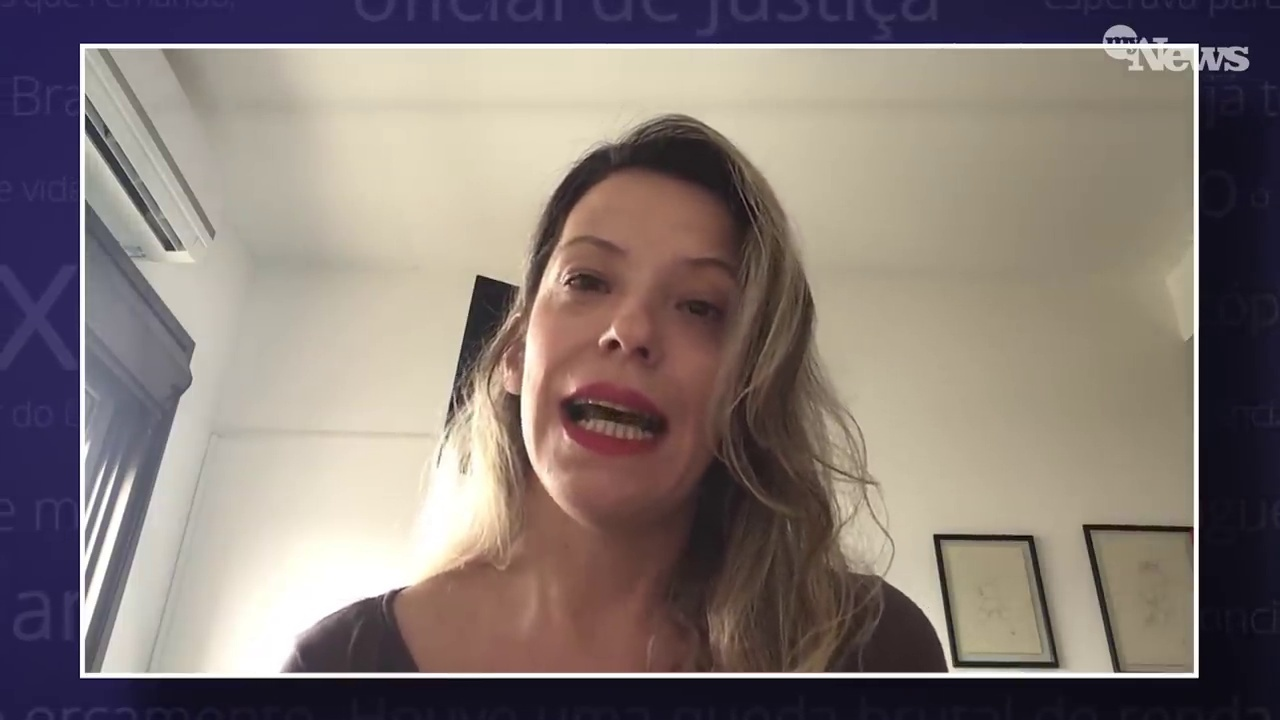


Paragraph: A white woman with surprise expression. She has blonde long hair. She is wearing a black tank top and makeup. She is in the office, with pictures in the background. 
----------------------------------------------------------------------------------------------------------------------------------



In [65]:
for num, img in enumerate(list_ids[:]):

    print("Image %d: %s" % (num+1, img))

    main([img], questions, threshold_sim, threshold_yes, path_dts, 
         device, nlp, parser, phoney, inflect, 
         tokenizer_roberta, model_roberta, model_vqa, 
         annotations_list, densecap_model, dense_captions_extracted, dense_used)


### VIIDA with Dense Captioning model (GRIT and DenseCap)

Image 1: pfax5gMOfmA#99480.jpg


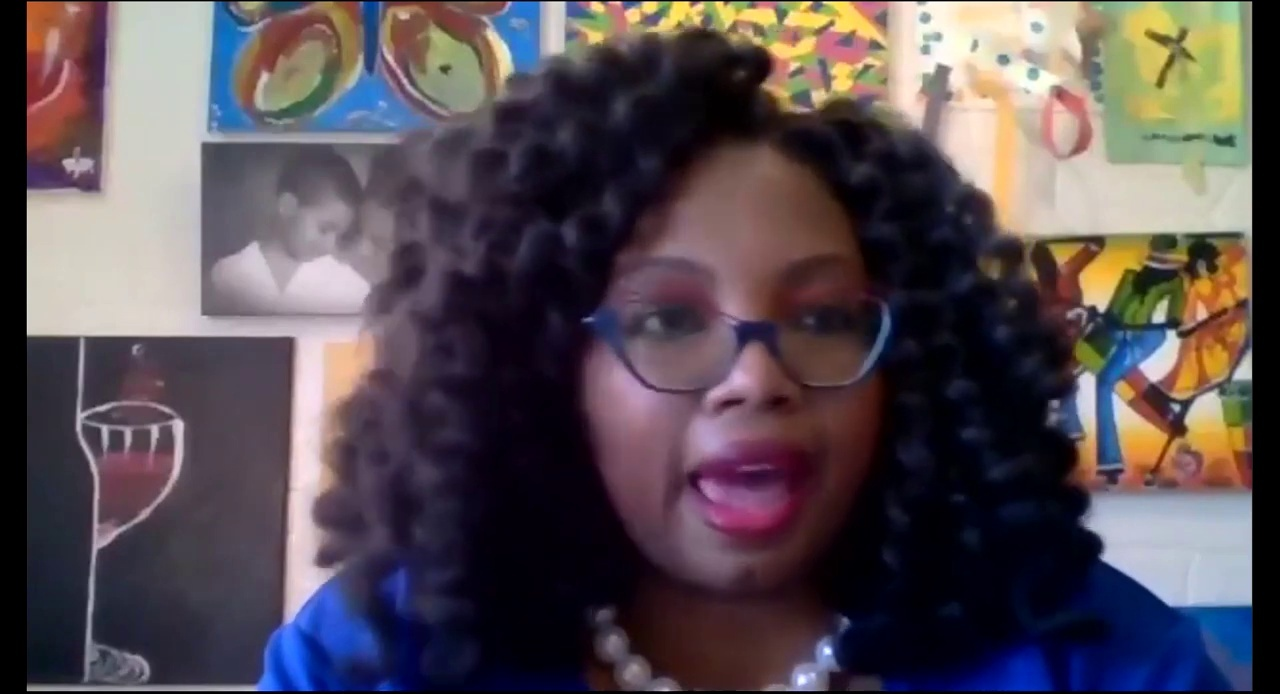


Paragraph: A black woman with surprised expression. She has black long hair. She is wearing a blue jacket and black glasses. She is in the living room, with an art in the background. A poster on the wall. Colorful painting in the background. 
----------------------------------------------------------------------------------------------------------------------------------



In [102]:
for num, img in enumerate(list_ids[:]):

    print("Image %d: %s" % (num+1, img))

    main([img], questions, threshold_sim, threshold_yes, path_dts, 
         device, nlp, parser, phoney, inflect, 
         tokenizer_roberta, model_roberta, model_vqa, 
         annotations_list, densecap_model, dense_captions_extracted, dense_used)


Image 1: SG0yy27KPjY#47520.jpg


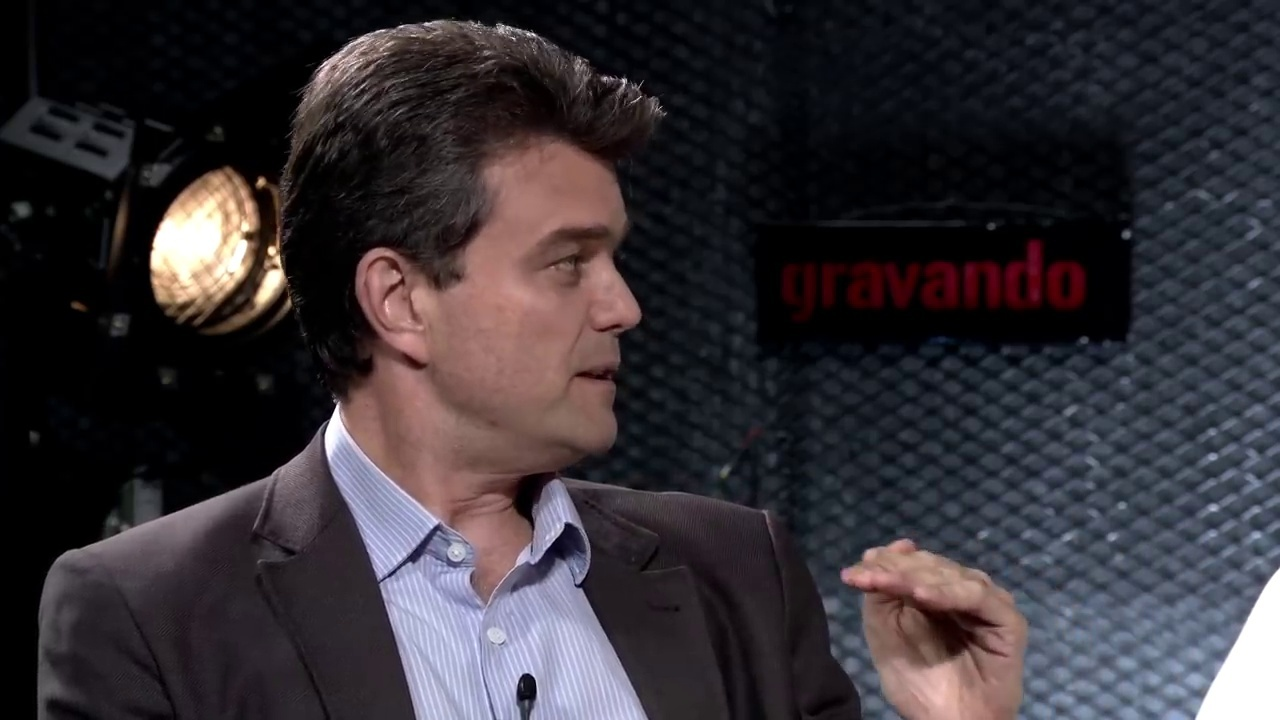


Paragraph: A white man with serious expression. He has brown eyes and brown short hair. He is wearing a gray suit. He is in the business, with lights in the background. A light on a pole. 
----------------------------------------------------------------------------------------------------------------------------------

Image 2: JnqQSpTlXQg#99000.jpg


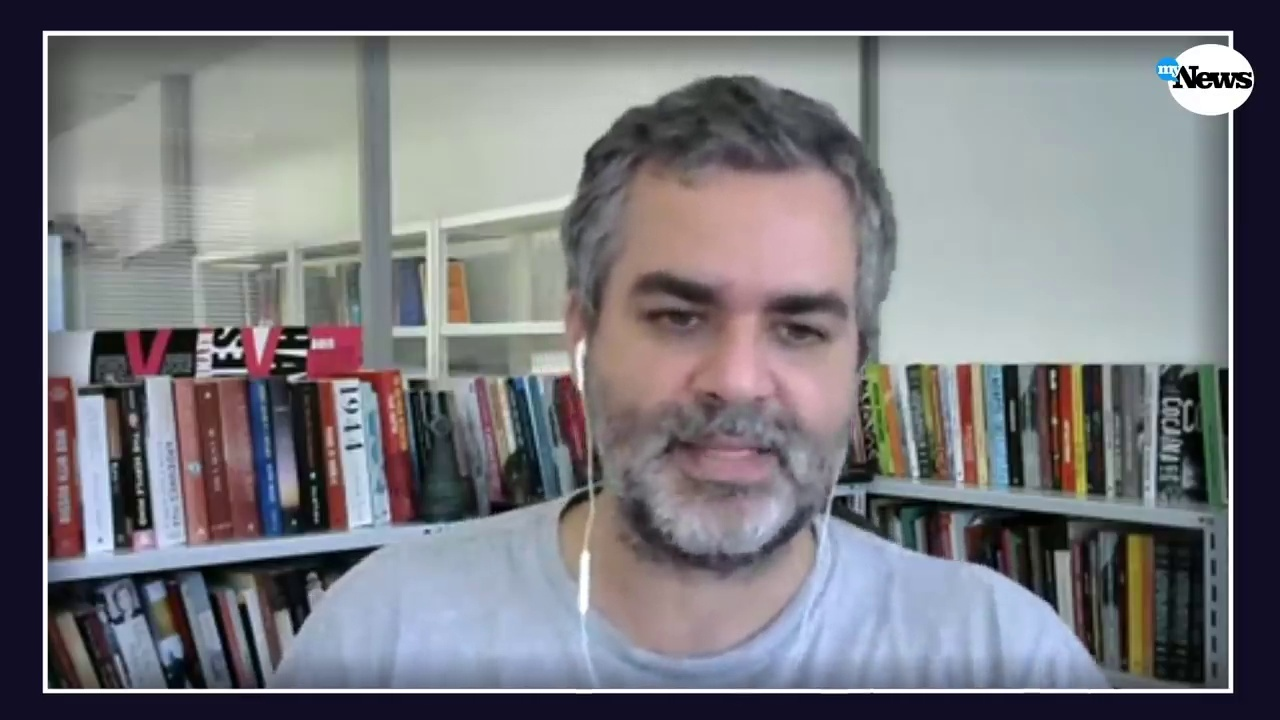


Paragraph: A midlife white man with serious expression. He has brown eyes, gray short hair, gray mustache and gray short beard. He is wearing a gray t shirt. He is in the library, with books in the background. A book shelf with books. 
----------------------------------------------------------------------------------------------------------------------------------



In [62]:
for num, img in enumerate(list_ids[:]):

    print("Image %d: %s" % (num+1, img))

    main([img], questions, threshold_sim, threshold_yes, path_dts, 
         device, nlp, parser, phoney, inflect, 
         tokenizer_roberta, model_roberta, model_vqa, 
         annotations_list, densecap_model, dense_captions_extracted, dense_used)
